## Mounting Drive

In [0]:
from google.colab import drive

In [26]:
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data

In [0]:
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/Model: Somya/data'

In [0]:
import skimage.io as io
import glob
import os
import numpy as np

In [29]:
imgs = []
for i in range(1, 13):
    print(f'Current Directory: {i}')
    curr_dir = os.path.join(DATA_DIR, str(i))
    img_paths = glob.glob(os.path.join(curr_dir, '*.png'))
    
    curr_path_imgs = []
    for img_path in img_paths:
        img = io.imread(img_path)
        curr_path_imgs.append(img)
        
    curr_path_imgs_np = np.array(curr_path_imgs)
    print(curr_path_imgs_np.shape)
    imgs.append(curr_path_imgs_np)
    
imgs_np = np.array(imgs)

Current Directory: 1
(32, 300, 300, 3)
Current Directory: 2
(32, 300, 300, 3)
Current Directory: 3
(32, 300, 300, 3)
Current Directory: 4
(32, 300, 300, 3)
Current Directory: 5
(32, 300, 300, 3)
Current Directory: 6
(32, 300, 300, 3)
Current Directory: 7
(32, 300, 300, 3)
Current Directory: 8
(32, 300, 300, 3)
Current Directory: 9
(32, 300, 300, 3)
Current Directory: 10
(32, 300, 300, 3)
Current Directory: 11
(32, 300, 300, 3)
Current Directory: 12
(32, 300, 300, 3)


In [0]:
n_classes, n_samples, h, w, channels = imgs_np.shape

## Model

In [0]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

import numpy.random as rng
from sklearn.utils import shuffle
import numpy as np

import time

In [0]:
def initialize_weights(shape, dtype):
    return np.random.normal(loc=0, scale=1e-2, size=shape)

In [0]:
def initialize_bias(shape, dtype):
    return np.random.normal(loc=0.5, scale=1e-2, size=shape)

In [0]:
def get_siamese_model(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = Sequential([
        Conv2D(filters=64, kernel_size=(25,25), activation='relu', input_shape=input_shape, 
               kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)),
        MaxPooling2D(),
        Conv2D(filters=64, kernel_size=(11,11), activation='relu', input_shape=input_shape, 
               kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)),
        MaxPooling2D(),
        Conv2D(filters=128, kernel_size=(7,7), activation='relu', kernel_initializer=initialize_weights, 
               bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)),
        MaxPooling2D(),
        Conv2D(filters=128, kernel_size=(4,4), activation='relu', kernel_initializer=initialize_weights, 
               bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)),
        MaxPooling2D(),
        Conv2D(filters=256, kernel_size=(4,4), activation='relu', kernel_initializer=initialize_weights, 
               bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)),
        MaxPooling2D(),
        Flatten(),
        Dense(units=4096, activation='sigmoid', kernel_initializer=initialize_weights, 
              kernel_regularizer=l2(1e-3), bias_initializer=initialize_bias)
    ])
    
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    l1_layer = Lambda(lambda x: K.abs(x[0] - x[1]))
    l1_distance = l1_layer([encoded_l, encoded_r])
    
    prediction = Dense(units=1, activation='sigmoid', kernel_initializer=initialize_weights, 
                       bias_initializer=initialize_bias)(l1_distance)
    
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    
    return siamese_net

In [0]:
model = get_siamese_model((300, 300, 3))

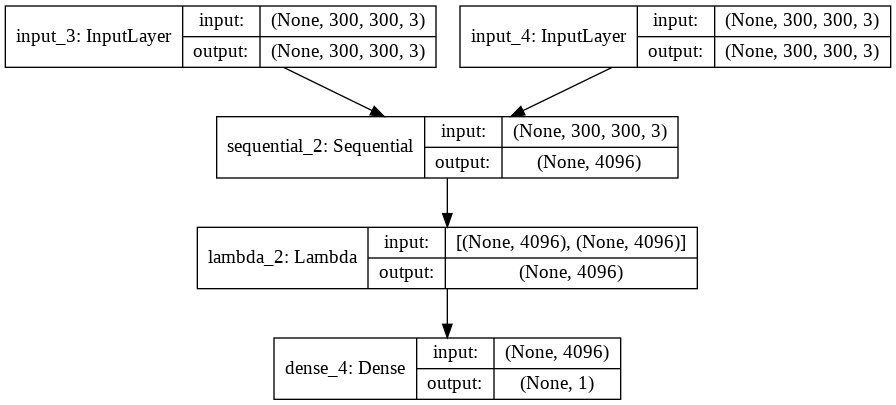

In [36]:
from keras.utils import plot_model
plot_model(model, 'model.png', show_shapes=True)

In [37]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         28022592    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_2[1][0]         

## Training Utils

In [0]:
def get_batch(batch_size):
    categories = np.random.choice(n_classes, size=(batch_size,), replace=True)
    pairs = [np.zeros((batch_size, h, w, 3)) for i in range(2)]
    targets = np.zeros((batch_size,))
    targets[batch_size // 2:] = 1
    
    for i in range(batch_size):
        cat_1 = categories[i]
        if i >= batch_size // 2:
            cat_2 = cat_1
        else:
            cat_2 = (cat_1 + np.random.randint(1, n_classes)) % n_classes
        
        idx_1 = np.random.randint(0, n_samples)
        idx_2 = np.random.randint(0, n_samples)
        pairs[0][i,:,:,:] = imgs_np[cat_1, idx_1]
        pairs[1][i,:,:,:] = imgs_np[cat_2, idx_2]
        
    return pairs, targets

In [0]:
optimizer = Adam(lr=6e-5)

In [0]:
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def generate_batch(batch_size, dataset='train'):
    while True:
        pairs, targets = get_batch(batch_size, 'train')
        yield (pairs, targets)

In [0]:
def make_one_shot_task(n):
    indices = np.random.randint(0, n_samples, size=(n,))
    categories = np.random.choice(n_classes, size=(n,), replace=True)
    true_category = categories[0]
    idx = np.random.randint(0, n_samples)
    test_image = np.repeat(np.expand_dims(imgs_np[i, image_idx, :,:,:], 0), repeats=n_classes, axis=0)
    support_set = imgs_np[categories, indices, :,:,:]
    targets = np.zeros((n,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    
    pairs = [test_image, support_set]
    
    return pairs, targets

In [0]:
def test_one_shot(model, n, k):
    n_correct = 0
    print(f'Evaluating model on {k} random {n} way one-shot learning tasks...\n')
    for i in range(k):
        inputs, targets = make_one_shot_task(n)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
            
    percent_correct = (100.0 * n_correct) / k
    
    print(f'Got an average of {percent_correct}% samples\n')
    
    return percent_correct

## Hyperparameters

In [0]:
evaluate_every = 200
batch_size = 32
n_iter = 20000
n_way = 20
n_val = 250
best = -1

## Loading Model

In [0]:
MODEL_WEIGHTS_PATH = '/content/drive/My Drive/Colab Notebooks/Model: Somya/weights'

In [0]:
model.load_weights(os.path.join(MODEL_WEIGHTS_PATH, 'weights.3200.h5'))

## Training Model

In [0]:
MODEL_WEIGHTS_SAVE_PATH = './weights'

In [0]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_one_shot(model, n_way, n_val)
        model.save_weights(os.path.join(MODEL_WEIGHTS_SAVE_PATH, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------



 ------------- 

Time for 200 iterations: 8.71524061759313 mins
Train Loss: [1.3912469, 1.0]
Evaluating model on 250 random 20 way one-shot learning tasks...

Got an average of 46.4% samples

Current best: 46.4, previous best: -1

 ------------- 

Time for 400 iterations: 20.688540450731914 mins
Train Loss: [0.9627432, 0.96875]
Evaluating model on 250 random 20 way one-shot learning tasks...

Got an average of 40.4% samples


 ------------- 

Time for 600 iterations: 32.61518013079961 mins
Train Loss: [0.73143953, 0.96875]
Evaluating model on 250 random 20 way one-shot learning tasks...

Got an average of 49.2% samples

Current best: 49.2, previous best: 46.4

 ------------- 

Time for 800 iterations: 44.53070636590322 mins
Train Loss: [0.58088464, 1.0]
Evaluating model on 250 random 20 way one-shot learning tasks...

Got an average of 42.4% samples


 ------------- 

Time for 1000 iterations: 56.439568841457366 mins
T

KeyboardInterrupt: ignored

## Model Testing

In [0]:
sample_indices = np.random.choice(n_samples, size=(n_classes,), replace=True)

In [55]:
sample_indices

array([10, 30, 22, 20,  8, 27, 15, 31, 23, 13,  4,  0])

In [0]:
support_set = imgs_np[range(n_classes), sample_indices, :,:,:]

In [57]:
support_set.shape

(12, 300, 300, 3)

In [67]:
for i in range(n_classes):
    image_idx = np.random.randint(0, n_samples)
    test_image = np.repeat(np.expand_dims(imgs_np[i, image_idx, :,:,:], 0), repeats=n_classes, axis=0)
    inputs = [test_image, support_set]
    probs = model.predict(inputs)
    if np.argmax(probs) == i:
        print('Correct')
    else:
        print('Incorrect')

Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct


In [0]:
os.mkdir('model')

In [0]:
MODEL_SAVE_DIR = './model'

In [0]:
model.save(os.path.join(MODEL_SAVE_DIR, 'model.h5'))